# Example of rotational and hyperfine quadrupole spectrum of Benzal Chrolide

<img src="../etc/data/benzal_cloride/benzal_chloride.png" alt="benzal chloride structure" width="300"/>

This example simulates the rotational hyperfine spectrum of benzal chloride, arising from the nuclear quadrupole interaction of two chlorine atoms. Each chlorine nucleus has spin $I = \tfrac{3}{2}$ and a nuclear quadrupole moment of $Q = -81.65$ mb (see Pyykkö, Year-2008 Nuclear Quadrupole Moments,
Mol. Phys. 106 (2008) 1965. DOI: 10.1080/0026897080201836)

The molecular geometry, dipole moment, and electric field gradient tensors used in this simulation are defined in the module [benzal_chroride.py](benzal_chloride.py)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# benzal chloride molecular constants
from benzal_chloride import (
    atom_labels,
    atom_masses,
    atom_xyz,
    dip_mol,
    efg_mol_cl1,
    efg_mol_cl2,
)
from scipy import constants
from scipy.sparse import csr_array

from richmol import CartTensor, HyperCartTensor, HyperStates, QuadMom, RotStates
from richmol.asymtop import inertia_tensor

Compute rotational states and matrix elements of dipole moment operator.

In [2]:
# Rotate Cartesian coordinates and tensors to principal axes system (PAS)

# inertia tensor
imom = inertia_tensor(atom_masses, atom_xyz)

# PAS rotation matrix
d, v = np.linalg.eigh(imom)
pas = v.T

atom_xyz_pas = atom_xyz @ pas.T

# check that inertia tensor is diagonal in PAS
imom = inertia_tensor(atom_masses, atom_xyz_pas)

dip_pas = pas @ np.array(dip_mol)
efg_pas_cl1 = pas @ np.array(efg_mol_cl1) @ pas.T
efg_pas_cl2 = pas @ np.array(efg_mol_cl2) @ pas.T

print("Dipole moment in PAS:\n", dip_pas)
print("EFG on Cl1 in PAS:\n", efg_pas_cl1)
print("EFG on Cl2 in PAS:\n", efg_pas_cl2)

# Compute rotational states and matrix elements of laboratory-frame dipole

xyz = [[atom, *xyz] for atom, xyz in zip(atom_labels, atom_xyz_pas)]
xyz = ["Cs"] + [el for elem in xyz for el in elem]

jmax = 30
states = RotStates.from_geometry(jmax, xyz)

dip_lab = CartTensor(states, dip_mol)
efg_lab_cl1 = CartTensor(states, efg_mol_cl1)
efg_lab_cl2 = CartTensor(states, efg_mol_cl2)

Dipole moment in PAS:
 [-8.79156932e-01  3.06434638e-05  3.08840950e-01]
EFG on Cl1 in PAS:
 [[-0.78502781  2.21032713 -0.97937708]
 [ 2.21032713  2.08402305 -1.59924763]
 [-0.97937708 -1.59924763 -1.29899515]]
EFG on Cl2 in PAS:
 [[-0.78490201 -2.21068259 -0.97882876]
 [-2.21068259  2.08484739  1.59809412]
 [-0.97882876  1.59809412 -1.29994528]]

Compute rigid-rotor solutions using molecular geometry as input
Cartesian units: angstrom, conversion to Angstrom: 1
  Atom           Mass (u)              X (Å)              Y (Å)              Z (Å)
    Cl    34.968852694000     2.537367216851     1.475254651699    -0.113089720750
    Cl    34.968852694000     2.537441990328    -1.475259282251    -0.112633204943
     C    12.000000000000     0.244433802288    -0.000002515046     0.207119998614
     C    12.000000000000    -0.665295722677     0.000288728501     1.261608522368
     C    12.000000000000    -0.226765572707    -0.000328869734    -1.106433533445
     C    12.000000000000     1.709

Compute hyperfine states from nuclear quadrupole interaction of Cl atoms. Transform rotational matrix elements of dipole moment operator to hyperfine basis.

In [ ]:
# Compute hyperfine states and matrix elements of laboratory-frame dipole

# quadrupole moments (in mb) from Pyykkö, "Year-2008 nuclear quadrupole moments",
#   Mol. Phys. 106 (2008) 1965, http://dx.doi.org/10.1080/00268970802018367
quad_cl = QuadMom(spin=3 / 2, Q=-81.65)


# Define symmetry coupling rules between rotational and nuclear spin states.
# Each Cl nucleus has spin I = 3/2, so the total nuclear spin (I_total) can be 0, 1, 2, or 3.
# The corresponding nuclear spin symmetries are A", A', A", and A', respectively.
#
# Due to the Pauli exclusion principle, the total spin-rotational wavefunction must be
# antisymmetric (A") under exchange of the two identical fermionic Cl nuclei.
#
# As a result:
# - Nuclear spin states with I_total = 0 and 2 (A" symmetry) must couple to rotational states with A' symmetry.
# - Nuclear spin states with I_total = 1 and 3 (A' symmetry) must couple to rotational states with A" symmetry.
#
# The function `symmetry_rules` below encodes these selection rules.
#
# Important note: since dipole transitions are not changing the total spin, pure rotational transitions
# are allowed between rotational states of the same symmetry, i.e., A'<-->A' and A"<-->A".


def symmetry_rules(
    j_list: list[int],
    j_sym_list: dict[int, list[str]],
    spin_list: list[tuple[float]],
) -> dict[str, list[tuple[int, tuple[float], str, str]]]:
    """Generates allowed spin-rotational symmetry combinations based
    on rotational and spin quantum numbers and symmetry labels.

    Returns a dictionary mapping resulting total (spin-rotational) symmetry
    labels to the corresponding combinations of rotational and spin quantum
    numbers and symmetries that yield them.

    Args:
        j_list (list[int]):
            List of rotational angular momentum quantum numbers J.

        j_sym_list (dict[int, list[str]]):
            Dictionary containing list of rotational symmetry labels for each J.

        spin_list (list[tuple[float]]):
            List of spin quantum numbers, each represented as a tuple
            (containing intermediate spin quanta).
            The total spin is given by the last value in each tuple.

    Returns:
        dict[str, list[tuple[int, tuple[float], str, str]]]:
            A dictionary where each key is a spin-rotational symmetry label (str),
            and each value is a list of tuples of the form:
                (J, spin_tuple, rotational_symmetry, spin_symmetry)
            representing the rotational and spin state components whose direct product
            yields the given key symmetry.

    Example:
        {
            'A"': [
                (1, (1.5, 0), "A'", 'A"'),
                (1, (1.5, 1), 'A"', "A'"),
                (1, (1.5, 2), "A'", 'A"'),
                ...
            ],
            ...
        }
    """
    cs_prod = {
        ("A'", 'A"'): 'A"',
        ('A"', "A'"): 'A"',
        # ("A'", "A'"): "A'", # forbidden by Pauli principle
        # ('A"', 'A"'): "A'", # forbidden by Pauli principle
    }
    j_spin_list = {'A"': []}
    for j, spin in zip(j_list, spin_list):
        tot_spin = spin[-1]  # can be 0, 1, 2, 3
        for j_sym in j_sym_list[j]:
            if tot_spin in (1, 3):
                spin_sym = "A'"
            elif tot_spin in (0, 2):
                spin_sym = 'A"'
            else:
                raise ValueError(
                    f"Symmetry of state with total spin = {tot_spin} is not defined"
                )
            try:
                f_sym = cs_prod[(j_sym, spin_sym)]
            except KeyError:
                continue
            j_spin_list[f_sym].append((j, spin, j_sym, spin_sym))
    return j_spin_list


# compute hyperfine states

hyper_states = HyperStates(
    0.0,
    27.0,
    states,
    spin_op=[quad_cl, quad_cl],
    efg_op=[efg_lab_cl1, efg_lab_cl2],
    symmetry_rules=symmetry_rules,
)

# transform matrix elements of dipole moment to hyperfine basis

hyper_dip_lab = HyperCartTensor(hyper_states, dip_lab)


Compute hyperfine states
List of F quanta: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(27.0)]
F   tot.sym.   J   (I_1, I_12, ... I_1N)     rovib.sym.   spin.sym.  rovib.dim 
----------------------------------------------------------------------------
0.0 A"         0   (1.5, 0)                  A'           A"         1         
0.0 A"         1   (1.5, 1)                  A"           A'         2         
0.0 A"         2   (1.5, 2)                  A'           A"         3         
0.0 A"         3   (1.5, 3)                  A"           A'    

Define functions for computing dipole linestrengths and temperature-dependent cross-section

In [ ]:
def dipole_linestr(
    dip: CartTensor,
) -> dict[tuple[int | float, int | float], dict[tuple[str, str], csr_array]]:
    """Computes dipole transition linestrengths from a lab-frame dipole moment tensor `dip`.

    The line strength is calculated by summing over the (2J + 1) magnetic sublevels.
    The result is organized hierarchically by total angular momenta (J) and symmetry labels.

    Args:
        dip (CartTensor): Matrix elements of lab-frame dipole moment tensor.

    Returns:
        dict: A nested dictionary structure:
            {
                (J1, J2): {
                    (sym1, sym2): csr_array
                }
            }
            where:
                - (J1, J2): Tuple of total angular momenta for the initial and final states.
                - (sym1, sym2): Tuple of symmetry labels for the initial and final states.
                - csr_array: A sparse matrix in CSR format with elements corresponding to
                    line strengths between states |J1, sym1, l1⟩ and |J2, sym2, l2⟩, summed
                    over magnetic quantum numbers.
    """
    assert (
        dip.rank == 1
    ), f"Unexpected rank of the input 'dip' tensor = {dip.rank} (must be equal to 1)"

    ls = {}
    for j_pair in list(set(dip.mmat.keys()) & set(dip.kmat.keys())):
        mmat = dip.mmat[j_pair]
        kmat = dip.kmat[j_pair]

        m_prefac = np.sum(
            [np.sum(np.abs(mmat_cart[1]) ** 2) for mmat_cart in mmat.values()]
        )  # must be equal to (2*j1+1)*(2*j2+1), where j1,j2=j_pair

        ls_sym = {}
        for sym_pair, kmat_s in kmat.items():
            ls_sym[sym_pair] = m_prefac * np.abs(kmat_s[1]) ** 2

        if ls_sym:
            ls[j_pair] = ls_sym

    return ls


def convolute_lorentz(points, x, y, width):
    f = np.zeros(len(points))
    for i in range(len(x)):
        f += y[i] * 1 / np.pi * 0.5 * width / ((points - x[i]) ** 2 + 0.25 * width**2)
    return f


def crossec(
    states: RotStates | HyperStates,
    dip: CartTensor,
    points: np.ndarray,
    width: float,
    temp: float,
    gns: dict[str, float] = None,
    allowed_tran_sym: list[tuple[str, str]] = None,
) -> tuple[np.ndarray, float]:
    """Computes a temperature-dependent absorption cross section using a Lorentzian line profile
    (see `convolute_lorentz`).

    Args:
        states (RotStates or HyperStates):
            Quantum states of the molecule, either purely rotational
            or including hyperfine structure.

        dip (CartTensor):
            Laboratory-frame dipole moment matrix elements between the states.

        points (np.ndarray):
            1D array of frequency values (in cm^{-1}) at which the absorption
            cross section is evaluated.

        width (float):
            Full width at half maximum (FWHM) of the Lorentzian broadening
            function, in cm^{-1}.

        temp (float):
            Temperature in Kelvin, used to compute the Boltzmann population factors.

        gns (dict[str, float], optional):
            Nuclear spin statistical weights, specified as a dictionary keyed by symmetry
            labels of states. If not provided, uniform statistical weights are assumed.

        allowed_tran_sym (list[tuple[str, str]], optional):
            A list of state symmetry pairs (initial, final) defining allowed dipole
            transitions. Transitions are included if their symmetry matches a pair
            in this list (in either order).
            If not provided, no symmetry restrictions on transitions are imposed.

    Returns:
        tuple[np.ndarray, float]:
            - An array of absorption cross section values evaluated at each frequency
            in `points`.
            - The total partition function at the specified temperature.
    """
    kB = constants.value("Boltzmann constant in inverse meter per kelvin") / 100

    # dipole linestrenghts
    ls = dipole_linestr(dip)

    try:
        j_list = [j for j in states.j_list]
        sym_list = states.sym_list
    except AttributeError:
        j_list = [j for j in states.f_list]
        sym_list = states.f_sym_list

    energy = np.concatenate([states.enr[j][sym] for j in j_list for sym in sym_list[j]])

    # (2J+1) m-degeneracy
    m_degen = np.concatenate(
        [[2 * j + 1] * states.dim_k[j][sym] for j in j_list for sym in sym_list[j]]
    )

    # (2I+1) spin-degeneracy
    if gns is None:
        spin_degen = np.concatenate(
            [[1] * states.dim_k[j][sym] for j in j_list for sym in sym_list[j]]
        )
    else:
        spin_degen = np.concatenate(
            [[gns[sym]] * states.dim_k[j][sym] for j in j_list for sym in sym_list[j]]
        )

    # partition function
    zpe = np.min(energy)
    partfunc = np.sum(spin_degen * m_degen * np.exp(-(energy - zpe) / (kB * temp)))

    xsec = 0
    for j1 in j_list:
        for j2 in j_list:

            if j2 < j1 or (j1, j2) not in ls:
                continue
            ls_j = ls[(j1, j2)]

            for sym1 in sym_list[j1]:
                for sym2 in sym_list[j2]:

                    if (sym1, sym2) not in ls_j:
                        continue

                    if allowed_tran_sym is not None:
                        if (sym1, sym2) not in allowed_tran_sym and (
                            sym2,
                            sym1,
                        ) not in allowed_tran_sym:
                            continue

                    # linestrength is already summed over the m-degenerate states
                    ls_sym = ls_j[(sym1, sym2)]

                    e1 = states.enr[j1][sym1]
                    e2 = states.enr[j2][sym2]

                    if len(e1) == 0 or len(e2) == 0:
                        continue
                    nu = np.abs(e1[:, None] - e2[None, :])
                    g1 = (
                        np.array([gns[sym1]] * len(e1))
                        if gns is not None
                        else np.ones_like(e1)
                    )
                    g2 = (
                        np.array([gns[sym2]] * len(e2))
                        if gns is not None
                        else np.ones_like(e2)
                    )

                    cond = e1[:, None] < e2[None, :]
                    e_ini = np.where(cond, e1[:, None], e2[None, :])
                    spin_degen = np.where(cond, g1[:, None], g2[None, :])

                    if j1 == j2:
                        ind = np.triu_indices(n=len(e1), m=len(e2), k=1)
                    else:
                        ind = np.triu_indices(n=len(e1), m=len(e2), k=0)
                    s = ls_sym.toarray()[ind]
                    nu = nu[ind]
                    e_ini = e_ini[ind]
                    spin_degen = spin_degen[ind]

                    boltz = spin_degen * np.exp(-(e_ini - zpe) / (kB * temp)) / partfunc

                    xsec = xsec + convolute_lorentz(points, nu, s * boltz, width)

    return xsec, partfunc

Compute rotational and hyperfine cross-sections for selected frequency range and temperature.

In [24]:
temp = 300  # Kelvin

# nuclear-spin statistical weights for rotational states
gns = {"A'": 6, 'A"': 10}

nu1, nu2 = (0.396, 0.40)
npoints = 100000
width = 1e-5
points = np.linspace(nu1, nu2, npoints)

# rotational crossection
xs, partfunc = crossec(
    states,
    dip_lab,
    points,
    width,
    temp,
    gns=gns,
    allowed_tran_sym=[("A'", "A'"), ('A"', 'A"')],
)

# hyperfine crossection
hyper_xs, hyper_partfunc = crossec(hyper_states, hyper_dip_lab, points, width, temp)

Plot both crossections.

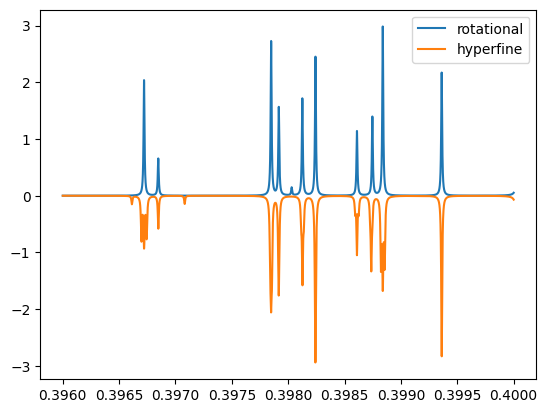

Crossection area
	Rotational: 0.0002991920443778226
	Hyperfine: 0.0003919455554872358
Partition function
	Rotational: 286219.68142155855
	Hyperfine: 214637.24333196244


In [25]:
from scipy.integrate import simpson

plt.plot(points, xs, label="rotational")
plt.plot(points, -hyper_xs, label="hyperfine")
plt.legend()
plt.show()

area = simpson(xs, points)
hyper_area = simpson(hyper_xs, points)

print("Crossection area")
print(f"\tRotational: {area}")
print(f"\tHyperfine: {hyper_area}")

print("Partition function")
print(f"\tRotational: {partfunc}")
print(f"\tHyperfine: {hyper_partfunc}")